In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
%matplotlib inline

DATASET_DIR = '../kaggle-dataset'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('fraud-detection').master("local[*]").getOrCreate()

In [4]:
spark.version

'3.1.1'

In [5]:
from pyspark.sql.types import FloatType

spark_df = spark.read.csv(os.path.join(DATASET_DIR, 'train.csv'), header = True, inferSchema = True)

for col in spark_df.columns:
    spark_df = spark_df.withColumn(col, spark_df[col].cast(FloatType()))

pos_spark_df = spark_df.filter(spark_df.Class == 1)
neg_spark_df = spark_df.filter(spark_df.Class == 0)
neg_spark_df_2 = neg_spark_df.limit(pos_spark_df.count())

spark_df_balanced = pos_spark_df.union(neg_spark_df_2)
spark_df_unbalanced = pos_spark_df.union(neg_spark_df)
print(spark_df_balanced.columns)
# print(spark_df_unbalanced.count())

['_c0', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [4]:
all_columns = spark_df_balanced.columns
print(all_columns)

['_c0', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

stages = []
all_input_cols = all_columns[1:-1]
print(all_input_cols)
assembler = VectorAssembler(inputCols=all_input_cols, outputCol="features")
stages += [assembler]


pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(spark_df_balanced)
pipelineModel.write().overwrite().save('saves/pipelineModelBalanced')
spark_df_balanced_2 = pipelineModel.transform(spark_df_balanced)
selectedCols = ['Class', 'features'] + all_input_cols
spark_df_balanced_2 = spark_df_balanced_2.select(selectedCols)
# spark_df_balanced_2.printSchema()

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [8]:
from pyspark.ml import PipelineModel

pipelineModelLoaded = PipelineModel.load("saves/pipelineModelBalanced")
spark_df_balanced_2 = pipelineModelLoaded.transform(spark_df_balanced)
selectedCols = ['Class', 'features'] + all_input_cols
spark_df_balanced_2 = spark_df_balanced_2.select(selectedCols)

In [9]:
train, test = spark_df_balanced_2.randomSplit([0.9, 0.1], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
# print(test.show(5))

Training Dataset Count: 884
Test Dataset Count: 100


In [10]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
save_path = 'saves/LRBalancedModel'

lr = LogisticRegression(featuresCol = 'features', labelCol = 'Class', maxIter=10)
lrModel = lr.fit(train)
lrModel.write().overwrite().save(save_path)

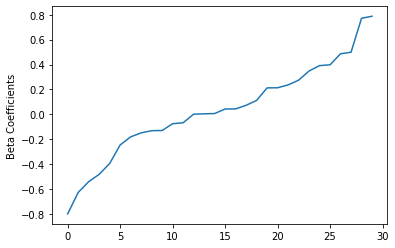

In [11]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

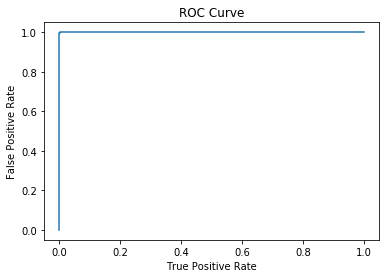

Training set areaUnderROC: 0.999994881323485


In [12]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


In [13]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
import pyspark.sql.functions as f

# read pickled model
persistedModel = LogisticRegressionModel.load(save_path)

# predict
predictionsDf = persistedModel.transform(test)

predictions = predictionsDf.select(f.collect_list('prediction')).first()[0]
print(predictions)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
# Does not work in Spark 2.4.6
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Class')
print('Test Area Under ROC', evaluator.evaluate(predictions))

AttributeError: 'list' object has no attribute '_jdf'

In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


## Unbalanced Model

In [145]:
pipelineUnbalancedModel = pipeline.fit(spark_df_unbalanced)
spark_df_unbalanced_2 = pipelineUnbalancedModel.transform(spark_df_unbalanced)
selectedCols = ['label', 'features'] + all_input_cols
spark_df_unbalanced_2 = spark_df_unbalanced_2.select(selectedCols)
# spark_df_balanced_2.printSchema()

In [150]:
train_unbalanced, test_unbalanced = spark_df_unbalanced_2.randomSplit([0.9, 0.1], seed = 2021)
print("Training Dataset Count: " + str(train_unbalanced.count()))
print("Test Dataset Count: " + str(test_unbalanced.count()))

lrUnbalancedModel = lr.fit(train_unbalanced)
lrModel.save('saves/LRUnbalancedModel')

Training Dataset Count: 230994
Test Dataset Count: 25824


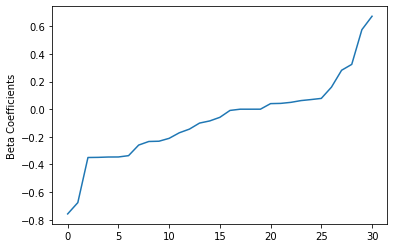

In [151]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrUnbalancedModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

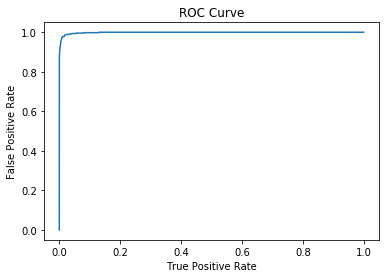

Training set areaUnderROC: 0.9985986932041188


In [149]:
trainingSummary = lrUnbalancedModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [156]:
from pyspark.sql.functions import rand 
test_randomized = test.orderBy(rand())

In [157]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

# read pickled model
persistedUnbalancedModel = LogisticRegressionModel.load('saves/LRUnbalancedModel')

# predict
predictions = persistedUnbalancedModel.transform(test_randomized)
predictions.select('label').show(10)

+-----+
|label|
+-----+
|    1|
|    0|
|    1|
|    0|
|    1|
|    0|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 10 rows

